<a href="https://colab.research.google.com/github/7yl4r/nasa-prithvi-wetlands/blob/main/prithvi_v2_eo_300_tl_unet_seagrass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# Includes work derived from International Business Machines
# https://github.com/IBM/ML4EO-workshop-2025/blob/main/Prithvi-EO/notebooks/prithvi_v2_eo_300_tl_unet_multitemporal_crop.ipynb
# Licensed under the Apache License, Version 2.0 (the "License");
# You may obtain a copy of the License at
#  http://www.apache.org/licenses/LICENSE-2.0
#
# All rights reserved for this derived work.

In [26]:
# Bash command to install dependencies from pyproject.toml with `pip``;
# ouput is piped to `tail`` to limit length of text printed below.
#!pip install -e . | tail -n 7

# install directly becausea gcolab does not have access to the pyproject.toml
!pip install terratorch

## Overview
This notebook focuses on fine-tuning the [Prithvi EO v2.0 model](https://huggingface.co/collections/ibm-nasa-geospatial/prithvi-for-earth-observation-6740a7a81883466bf41d93d6) to classify seagrass.

This notebook:
1. Is intended to be run on Google Colab.
2. Uses Terratorch to fine-tune Prithvi EO v2.0 300m.
3. Uses a seagrass patch dataset for fine-tuning derived from the IMaRS SIMM Seagrass Project.
4. Uses fine-tuned model for inference.

You may want to take this opportunity to double check you're using GPUs on Google Colab before proceeding any further.
We have tested the scaled-down (see section below) version of this notebook using T4 GPU on the free colab account.
For full-scale training the L4 runtime (pro account required) is used.

## Setup
1. Install terratorch

To install the necessary packages, execute the cell below. This will take a few minutes. Once the installation process is done, a window will pop up to ask you to restart the session. This is normal and you should proceed to restart using the interface in the pop up window. Once the session has restarted, its important that you ignore the cell below, and go straight to section 0.1.3.


2. Import dependencies

In [27]:

import albumentations
import gdown
import lightning.pytorch as pl
import os
import terratorch
import torch
import matplotlib.pyplot as plt
import warnings
from pathlib import Path
from terratorch.datamodules import MultiTemporalCropClassificationDataModule

warnings.filterwarnings('ignore')

In [28]:
from google.colab import drive
import os
import shutil

# Mount your Google Drive
drive.mount('/content/drive')

# Set paths
dataset_path = "data/tuning_patches"
fname = "seagrass_tuning_patches.tar.bz2"

# Path to your file in Google Drive (adjust this to match your file's location)
drive_file_path = "/content/drive/MyDrive/seagrass_tuning_patches.tar.bz2"

# Create destination directory if it doesn't exist
os.makedirs(dataset_path, exist_ok=True)

# Copy file from Drive to local Colab storage
shutil.copy(drive_file_path, os.path.join(dataset_path, fname))

# Unzip the file
!tar -xvjf {os.path.join(dataset_path, fname)}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


KeyboardInterrupt: 

A tuning dataset should now be in the dataset_path directory.
The dataset used is derived from the IMaRS SIMM Seagrasss Project.
For methods to generate the patches, see the `py/generate_seagrass_patches.py` script in the repo.



The patches need to be split into training and validation sets.
The sets are specified using a `.txt` file listing the patch file names for each set.
Example `training_chips.txt`:

```
chip_257_266
chip_328_501
chip_171_477
chip_236_281
chip_134_482
chip_120_493
chip_161_390
```

The training and validation patches are expected to be in `training_chips` and `validation_chips` subdirectories of the dataset path.

4. Truncate the dataset for demonstration purposes. Reducing the training dataset to a third of the original size means that model training takes only a few minutes with the resources available during the workshop.

In [ ]:
# training_data_truncation = 800
# validation_data_trunction = 4
# with open(f"{dataset_path}/training_data.txt", "r") as f:
#       training_data_list = f.readlines()
# truncated = training_data_list[0:training_data_truncation]
# with open(f"{dataset_path}/training_data.txt", "w") as f:
#     for i in truncated:
#         f.write(i)

# with open(f"{dataset_path}/validation_data.txt", "r") as f:
#       training_data_list = f.readlines()
# truncated = training_data_list[0:validation_data_trunction]
# with open(f"{dataset_path}/validation_data.txt", "w") as f:
#     for i in truncated:
#         f.write(i)

## Dataset Details

Lets start with analysing the dataset.

Please note: we have also set the batch_size parameter to 4 and max_epochs to 1 to avoid running out of memory or runtime for users of the free tier colab compute resources. This is enough to demonstrate the entire workflow to the user, but may not result in the best performance. It'll be best to find additional compute resources and increase batch_size and max_epochs in the downloaded config file for improved performance.


In [ ]:
# Each merged sample includes the stacked bands of three time steps
!ls "{dataset_path}/training_chips" | head

In [ ]:
# Modify parameters to select the batch size, number of workers, model backbone and epochs ahead of initalizing the MultiTemporalCropClassificationDataModule class for multi-temporal crop classification.
batch_size = 4
num_workers = 2
prithvi_backbone = "prithvi_eo_v2_300_tl" # Model can be either prithvi_eo_v1_100, prithvi_eo_v2_300, prithvi_eo_v2_300_tl, prithvi_eo_v2_600, prithvi_eo_v2_600_tl

# Total number of epochs the training will run for.
max_epochs =  1 # Use 1 epoch for demos


#### Initialise the Datamodules class

A Datamodule is a shareable, reusable class that encapsulates all the steps needed to process the data. Here we are using an adjusted dataset class for this dataset (general dataset class could be used as well). To learn more about MultiTemporalCropClassificationDataModule, take a look at the [TerraTorch docs](https://ibm.github.io/terratorch/stable/datamodules/?h=multitemporalcropclassificationdatamodule#terratorch.datamodules.multi_temporal_crop_classification.MultiTemporalCropClassificationDataModule).

In [ ]:
import glob
import os
from collections.abc import Sequence
from pathlib import Path
from typing import Any

import albumentations as A
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rioxarray
import torch
from einops import rearrange
from matplotlib.figure import Figure
from matplotlib.patches import Rectangle
from torch import Tensor
from torchgeo.datasets import NonGeoDataset
from xarray import DataArray

from terratorch.datasets.utils import clip_image, default_transform, filter_valid_files, validate_bands


class MultiTemporalSeagrassClassification(NonGeoDataset):
    """NonGeo dataset implementation for seagrass classification

    Based onhttps://github.com/terrastackai/terratorch/blob/main/terratorch/datasets/multi_temporal_crop_classification.py
    """

    all_band_names = (
        "COASTAL BLUE",
        "BLUE",
        "GREEN I",
        "GREEN II",
        "YELLOW",
        "RED",
        "RED-EDGE",
        "NEAR-INFRARED"
    )

    class_names = (
        "Non-Seagrass",
        "Seagrass",
    )

    rgb_bands = ("RED", "GREEN I", "BLUE")

    BAND_SETS = {"all": all_band_names, "rgb": rgb_bands}

    num_classes = 2
    time_steps = 3
    splits = {"train": "training", "val": "validation"}  # Only train and val splits available
    col_name = "chip_id"
    date_columns = ["first_img_date", "middle_img_date", "last_img_date"]

    def __init__(
        self,
        data_root: str,
        split: str = "train",
        bands: Sequence[str] = BAND_SETS["all"],
        transform: A.Compose | None = None,
        no_data_replace: float | None = None,
        no_label_replace: int | None = None,
        expand_temporal_dimension: bool = True,
        reduce_zero_label: bool = True,
        use_metadata: bool = False,
        metadata_file_name: str = "chips_df.csv",
    ) -> None:
        """Constructor

        Args:
            data_root (str): Path to the data root directory.
            split (str): one of 'train' or 'val'.
            bands (list[str]): Bands that should be output by the dataset. Defaults to all bands.
            transform (A.Compose | None): Albumentations transform to be applied.
                Should end with ToTensorV2(). If used through the corresponding data module,
                should not include normalization. Defaults to None, which applies ToTensorV2().
            no_data_replace (float | None): Replace nan values in input images with this value.
                If None, does no replacement. Defaults to None.
            no_label_replace (int | None): Replace nan values in label with this value.
                If none, does no replacement. Defaults to None.
            expand_temporal_dimension (bool): Go from shape (time*channels, h, w) to (channels, time, h, w).
                Defaults to True.
            reduce_zero_label (bool): Subtract 1 from all labels. Useful when labels start from 1 instead of the
                expected 0. Defaults to True.
            use_metadata (bool): whether to return metadata info (time and location).
        """
        super().__init__()
        if split not in self.splits:
            msg = f"Incorrect split '{split}', please choose one of {self.splits}."
            raise ValueError(msg)
        split_name = self.splits[split]
        self.split = split

        validate_bands(bands, self.all_band_names)
        self.bands = bands
        self.band_indices = np.asarray([self.all_band_names.index(b) for b in bands])
        self.data_root = Path(data_root)

        data_dir = self.data_root / f"{split_name}_chips"
        self.image_files = sorted(glob.glob(os.path.join(data_dir, "*_merged.tif")))
        self.segmentation_mask_files = sorted(glob.glob(os.path.join(data_dir, "*.mask.tif")))
        split_file = self.data_root / f"{split_name}_data.txt"

        with open(split_file) as f:
            split = f.readlines()
        valid_files = {rf"{substring.strip()}" for substring in split}
        self.image_files = filter_valid_files(
            self.image_files,
            valid_files=valid_files,
            ignore_extensions=True,
            allow_substring=True,
        )
        self.segmentation_mask_files = filter_valid_files(
            self.segmentation_mask_files,
            valid_files=valid_files,
            ignore_extensions=True,
            allow_substring=True,
        )

        self.no_data_replace = no_data_replace
        self.no_label_replace = no_label_replace
        self.reduce_zero_label = reduce_zero_label
        self.expand_temporal_dimension = expand_temporal_dimension
        self.use_metadata = use_metadata
        self.metadata = None
        self.metadata_file_name = metadata_file_name
        if self.use_metadata:
            metadata_file = self.data_root / self.metadata_file_name
            self.metadata = pd.read_csv(metadata_file)
            self._build_image_metadata_mapping()

        # If no transform is given, apply only to transform to torch tensor
        self.transform = transform if transform else default_transform

    def _build_image_metadata_mapping(self):
        """Build a mapping from image filenames to metadata indices."""
        self.image_to_metadata_index = dict()

        for idx, image_file in enumerate(self.image_files):
            image_filename = Path(image_file).name
            image_id = image_filename.replace("_merged.tif", "").replace(".tif", "")
            metadata_indices = self.metadata.index[self.metadata[self.col_name] == image_id].tolist()
            self.image_to_metadata_index[idx] = metadata_indices[0]

    def __len__(self) -> int:
        return len(self.image_files)

    def _get_date(self, row: pd.Series) -> torch.Tensor:
        """Extract and format temporal coordinates (T, date) from metadata."""
        temporal_coords = []
        for col in self.date_columns:
            date_str = row[col]
            date = pd.to_datetime(date_str)
            temporal_coords.append([date.year, date.dayofyear - 1])

        return torch.tensor(temporal_coords, dtype=torch.float32)

    def _get_coords(self, image: DataArray) -> torch.Tensor:
        px = image.x.shape[0] // 2
        py = image.y.shape[0] // 2

        # get center point to reproject to lat/lon
        point = image.isel(band=0, x=slice(px, px + 1), y=slice(py, py + 1))
        point = point.rio.reproject("epsg:4326")

        lat_lon = np.asarray([point.y[0], point.x[0]])

        return torch.tensor(lat_lon, dtype=torch.float32)

    def __getitem__(self, index: int) -> dict[str, Any]:
        image = self._load_file(self.image_files[index], nan_replace=self.no_data_replace)

        location_coords, temporal_coords = None, None
        if self.use_metadata:
            location_coords = self._get_coords(image)
            metadata_idx = self.image_to_metadata_index.get(index, None)
            if metadata_idx is not None:
                row = self.metadata.iloc[metadata_idx]
                temporal_coords = self._get_date(row)

        # to channels last
        image = image.to_numpy()
        if self.expand_temporal_dimension:
            image = rearrange(image, "(channels time) h w -> channels time h w", channels=len(self.bands))
        image = np.moveaxis(image, 0, -1)

        # filter bands
        image = image[..., self.band_indices]

        output = {
            "image": image.astype(np.float32),
            "mask": self._load_file(
                self.segmentation_mask_files[index], nan_replace=self.no_label_replace).to_numpy()[0],
            "filename": Path(self.image_files[index]).name,  # ADD THIS LINE
        }

        if self.reduce_zero_label:
            output["mask"] -= 1
        if self.transform:
            output = self.transform(**output)
        output["mask"] = output["mask"].long()

        if self.use_metadata:
            output["location_coords"] = location_coords
            output["temporal_coords"] = temporal_coords

        return output


    def _load_file(self, path: Path, nan_replace: int | float | None = None) -> DataArray:
        data = rioxarray.open_rasterio(path, masked=True)
        if nan_replace is not None:
            data = data.fillna(nan_replace)
        return data

    def plot(self, sample: dict[str, Tensor], suptitle: str | None = None) -> Figure:
        """Plot a sample from the dataset.

        Args:
            sample: a sample returned by :meth:`__getitem__`
            suptitle: optional string to use as a suptitle

        Returns:
            a matplotlib Figure with the rendered sample
        """
        num_images = self.time_steps + 2

        rgb_indices = [self.bands.index(band) for band in self.rgb_bands]
        if len(rgb_indices) != 3:
            msg = "Dataset doesn't contain some of the RGB bands"
            raise ValueError(msg)

        images = sample["image"]
        images = images[rgb_indices, ...]  # Shape: (T, 3, H, W)

        processed_images = []
        for t in range(self.time_steps):
            img = images[t]
            img = img.permute(1, 2, 0)
            img = img.numpy()
            img = clip_image(img)
            processed_images.append(img)

        mask = sample["mask"].numpy()
        if "prediction" in sample:
            num_images += 1
        fig, ax = plt.subplots(1, num_images, figsize=(12, 5), layout="compressed")
        ax[0].axis("off")

        norm = mpl.colors.Normalize(vmin=0, vmax=self.num_classes - 1)
        for i, img in enumerate(processed_images):
            ax[i + 1].axis("off")
            ax[i + 1].title.set_text(f"T{i}")
            ax[i + 1].imshow(img)

        ax[self.time_steps + 1].axis("off")
        ax[self.time_steps + 1].title.set_text("Ground Truth Mask")
        ax[self.time_steps + 1].imshow(mask, cmap="jet", norm=norm)

        if "prediction" in sample:
            prediction = sample["prediction"]
            ax[self.time_steps + 2].axis("off")
            ax[self.time_steps + 2].title.set_text("Predicted Mask")
            ax[self.time_steps + 2].imshow(prediction, cmap="jet", norm=norm)

        cmap = plt.get_cmap("jet")
        legend_data = [[i, cmap(norm(i)), self.class_names[i]] for i in range(self.num_classes)]
        handles = [Rectangle((0, 0), 1, 1, color=tuple(v for v in c)) for k, c, n in legend_data]
        labels = [n for k, c, n in legend_data]
        ax[0].legend(handles, labels, loc="center")

        if suptitle is not None:
            plt.suptitle(suptitle)

        return fig





from collections.abc import Sequence
from typing import Any

import albumentations as A
from torch import Tensor
from torch.utils.data import DataLoader
from torchgeo.datamodules import NonGeoDataModule

from terratorch.datamodules.generic_pixel_wise_data_module import Normalize
from terratorch.datamodules.utils import wrap_in_compose_is_list

# statistics calculated from patches using
# https://github.com/7yl4r/nasa-prithvi-wetlands/blob/main/py/calculate_chip_statistics.py
MEANS = {
    "COASTAL BLUE": 239.935709,
    "BLUE": 234.500603,
    "GREEN I": 284.371003,
    "GREEN II": 278.806835,
    "YELLOW": 282.793717,
    "RED": 237.836126,
    "RED-EDGE": 419.842239,
    "NEAR-INFRARED": 1086.378684
}

STDS = {
    "COASTAL BLUE": 129.262943,
    "BLUE": 152.548361,
    "GREEN I": 172.958055,
    "GREEN II": 187.841228,
    "YELLOW": 206.108674,
    "RED": 210.564642,
    "RED-EDGE": 245.177366,
    "NEAR-INFRARED": 451.722659
}


class MultiTemporalSeagrassClassificationDataModule(NonGeoDataModule):
    """NonGeo LightningDataModule implementation for multi-temporal seagrass classification.

    Based on https://github.com/terrastackai/terratorch/blob/main/terratorch/datamodules/multi_temporal_crop_classification.py
    """

    def __init__(
        self,
        data_root: str,
        batch_size: int = 4,
        num_workers: int = 0,
        bands: Sequence[str] = MultiTemporalSeagrassClassification.all_band_names,
        train_transform: A.Compose | None | list[A.BasicTransform] = None,
        val_transform: A.Compose | None | list[A.BasicTransform] = None,
        test_transform: A.Compose | None | list[A.BasicTransform] = None,
        predict_transform: A.Compose | None | list[A.BasicTransform] = None,
        drop_last: bool = True,
        no_data_replace: float | None = 0,
        no_label_replace: int | None = -1,
        expand_temporal_dimension: bool = True,
        reduce_zero_label: bool = True,
        use_metadata: bool = False,
        metadata_file_name: str = "chips_df.csv",
        **kwargs: Any,
    ) -> None:
        """
        Initializes the MultiTemporalCropClassificationDataModule for multi-temporal crop classification.

        Args:
            data_root (str): Directory containing the dataset.
            batch_size (int, optional): Batch size for DataLoaders. Defaults to 4.
            num_workers (int, optional): Number of workers for data loading. Defaults to 0.
            bands (Sequence[str], optional): List of bands to use. Defaults to MultiTemporalCropClassification.all_band_names.
            train_transform (A.Compose | None | list[A.BasicTransform], optional): Transformations for training data.
            val_transform (A.Compose | None | list[A.BasicTransform], optional): Transformations for validation data.
            test_transform (A.Compose | None | list[A.BasicTransform], optional): Transformations for testing data.
            predict_transform (A.Compose | None | list[A.BasicTransform], optional): Transformations for prediction data.
            drop_last (bool, optional): Whether to drop the last incomplete batch during training. Defaults to True.
            no_data_replace (float | None, optional): Replacement value for missing data. Defaults to 0.
            no_label_replace (int | None, optional): Replacement value for missing labels. Defaults to -1.
            expand_temporal_dimension (bool, optional): Go from shape (time*channels, h, w) to (channels, time, h, w).
                Defaults to True.
            reduce_zero_label (bool, optional): Subtract 1 from all labels. Useful when labels start from 1 instead of the
                expected 0. Defaults to True.
            use_metadata (bool): Whether to return metadata info (time and location).
            **kwargs: Additional keyword arguments.
        """
        super().__init__(MultiTemporalSeagrassClassification, batch_size, num_workers, **kwargs)
        self.data_root = data_root

        self.means = [MEANS[b] for b in bands]
        self.stds = [STDS[b] for b in bands]
        self.bands = bands
        self.train_transform = wrap_in_compose_is_list(train_transform)
        self.val_transform = wrap_in_compose_is_list(val_transform)
        self.test_transform = wrap_in_compose_is_list(test_transform)
        self.predict_transform = wrap_in_compose_is_list(predict_transform)
        self.aug = Normalize(self.means, self.stds)
        self.drop_last = drop_last
        self.no_data_replace = no_data_replace
        self.no_label_replace = no_label_replace
        self.expand_temporal_dimension = expand_temporal_dimension
        self.reduce_zero_label = reduce_zero_label
        self.use_metadata = use_metadata
        self.metadata_file_name = metadata_file_name

    def setup(self, stage: str) -> None:
        """Set up datasets.

        Args:
            stage: Either fit, validate, test, or predict.
        """
        if stage in ["fit"]:
            self.train_dataset = self.dataset_class(
                split="train",
                data_root=self.data_root,
                transform=self.train_transform,
                bands=self.bands,
                no_data_replace=self.no_data_replace,
                no_label_replace=self.no_label_replace,
                expand_temporal_dimension = self.expand_temporal_dimension,
                reduce_zero_label = self.reduce_zero_label,
                use_metadata=self.use_metadata,
                metadata_file_name=self.metadata_file_name,
            )
        if stage in ["fit", "validate"]:
            self.val_dataset = self.dataset_class(
                split="val",
                data_root=self.data_root,
                transform=self.val_transform,
                bands=self.bands,
                no_data_replace=self.no_data_replace,
                no_label_replace=self.no_label_replace,
                expand_temporal_dimension = self.expand_temporal_dimension,
                reduce_zero_label = self.reduce_zero_label,
                use_metadata=self.use_metadata,
                metadata_file_name=self.metadata_file_name,
            )
        if stage in ["test"]:
            self.test_dataset = self.dataset_class(
                split="val",
                data_root=self.data_root,
                transform=self.test_transform,
                bands=self.bands,
                no_data_replace=self.no_data_replace,
                no_label_replace=self.no_label_replace,
                expand_temporal_dimension = self.expand_temporal_dimension,
                reduce_zero_label = self.reduce_zero_label,
                use_metadata=self.use_metadata,
                metadata_file_name=self.metadata_file_name,
            )
        if stage in ["predict"]:
            self.predict_dataset = self.dataset_class(
                split="val",
                data_root=self.data_root,
                transform=self.predict_transform,
                bands=self.bands,
                no_data_replace=self.no_data_replace,
                no_label_replace=self.no_label_replace,
                expand_temporal_dimension = self.expand_temporal_dimension,
                reduce_zero_label = self.reduce_zero_label,
                use_metadata=self.use_metadata,
                metadata_file_name=self.metadata_file_name,
            )

    def _dataloader_factory(self, split: str) -> DataLoader[dict[str, Tensor]]:
        """Implement one or more PyTorch DataLoaders.

        Args:
            split: Either 'train', 'val', 'test', or 'predict'.

        Returns:
            A collection of data loaders specifying samples.

        Raises:
            MisconfigurationException: If :meth:`setup` does not define a
                dataset or sampler, or if the dataset or sampler has length 0.
        """
        dataset = self._valid_attribute(f"{split}_dataset", "dataset")
        batch_size = self._valid_attribute(f"{split}_batch_size", "batch_size")
        return DataLoader(
            dataset=dataset,
            batch_size=batch_size,
            shuffle=split == "train",
            num_workers=self.num_workers,
            collate_fn=self.collate_fn,
            drop_last=split == "train" and self.drop_last,
        )

In [ ]:
datamodule = MultiTemporalSeagrassClassificationDataModule(
    batch_size=batch_size,
    num_workers=num_workers,
    data_root=f"{dataset_path}",
    train_transform=[
        terratorch.datasets.transforms.FlattenTemporalIntoChannels(),  # Required for temporal data
        albumentations.D4(), # Random flips and rotation
        albumentations.pytorch.transforms.ToTensorV2(),
        terratorch.datasets.transforms.UnflattenTemporalFromChannels(n_timesteps=3),
    ],
    val_transform=None,  # Using ToTensor() by default
    test_transform=None,
    expand_temporal_dimension=True,
    use_metadata=False, # The crop dataset has metadata for location and time
    reduce_zero_label=True,
)

In [ ]:
# Setup train and val datasets
datamodule.setup("fit")

In [ ]:
datamodule.batch_size

In [ ]:
# Mean and standard deviation calculated from the training dataset for all 6 bands, and 3 timesteps, for zero mean normalization.
# checking for the dataset means and stds
datamodule.means, datamodule.stds

In [ ]:
# checking datasets train split size
train_dataset = datamodule.train_dataset
len(train_dataset)

In [ ]:
# checking datasets available bands
train_dataset.all_band_names

In [ ]:
# checking datasets classes
train_dataset.class_names

In [ ]:
split_name = "training"
print(f"[DEBUG] split={split_name}")
print(f"[DEBUG] found image files before filter: {len(glob.glob(os.path.join(dataset_path, "training_chips", '*_merged.tif')))}")
print(f"[DEBUG] found mask files before filter: {len(glob.glob(os.path.join(dataset_path, "training_chips", '*.mask.tif')))}")
print(f"[DEBUG] found image files after filter: {len(train_dataset.image_files)}")
print(f"[DEBUG] found mask files after filter: {len(train_dataset.segmentation_mask_files)}")


In [ ]:
len(datamodule.train_dataset)

In [ ]:
# plotting a few samples
for i in range(5):
    train_dataset.plot(train_dataset[i])

In [ ]:
# checking datasets validation split size
val_dataset = datamodule.val_dataset
len(val_dataset)

In [ ]:
# checking datasets testing split size
datamodule.setup("test")
test_dataset = datamodule.test_dataset
len(test_dataset)

# Fine-tune Prithvi

Here we setup the fine-tuning including which type of task, which head to use and the model parameters. In this case we are doing segemtation task (you can take a look at this and other downstream tasks here [TerraTorch docs](https://ibm.github.io/terratorch/stable/tasks/)) and using a unet decoder. We also set the numbers of images per label with the "backbone_num_frames" parameter to allow us to perform multi-temporal classification.

In [ ]:
pl.seed_everything(0)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    dirpath="../output/multicrop/checkpoints/",
    mode="max",
    monitor="val/mIoU", # Variable to monitor  # Changed from 'val/Multiclass_Jaccard_Index'
    filename="best-{epoch:02d}",
)


# Lightning Trainer
trainer = pl.Trainer(
    accelerator="auto",
    strategy="auto",
    devices=1, # Lightning multi-gpu often fails in notebooks
    precision='bf16-mixed',  # Speed up training
    num_nodes=1,
    logger=True, # Uses TensorBoard by default
    max_epochs=max_epochs,
    log_every_n_steps=5,
    enable_checkpointing=True,
    callbacks=[checkpoint_callback, pl.callbacks.RichProgressBar()],
    default_root_dir="../output/multicrop",
)

# Model
model = terratorch.tasks.SemanticSegmentationTask(
    model_factory="EncoderDecoderFactory",
    model_args={
        # Backbone
        "backbone": prithvi_backbone,
        "backbone_pretrained": True,
        "backbone_num_frames": 3,
        "backbone_bands": [
            "COASTAL BLUE",
            "BLUE",
            "GREEN I",
            "GREEN II",
            "YELLOW",
            "RED",
            "RED-EDGE",
            "NEAR-INFRARED"
        ],
        "backbone_coords_encoding": [], # use ["time", "location"] for time and location metadata

        # Necks
        "necks": [
            {
                "name": "SelectIndices",
                # "indices": [2, 5, 8, 11]  # 100m model
                "indices": [5, 11, 17, 23]  # 300m model
                # "indices": [7, 15, 23, 31]  # 300m model
            },
            {
                "name": "ReshapeTokensToImage",
                "effective_time_dim": 3
            },
            {"name": "LearnedInterpolateToPyramidal"},
        ],

        # Decoder
        "decoder": "UNetDecoder",
        "decoder_channels": [512, 256, 128, 64],

        # Head
        "head_dropout": 0.1,
        "num_classes": 13,
    },

    loss="ce",
    lr=1e-4,
    optimizer="AdamW",
    ignore_index=-1,
    freeze_backbone=True,  # Speeds up fine-tuning
    freeze_decoder=False,
    plot_on_val=True,
)

In [ ]:
# Training
trainer.fit(model, datamodule=datamodule)

# Test the fine-tuned model

Let's gather and specify the relevant files for carrying out testing. Look for your .ckpt file produced during the fine-tuning process here it is in '../output/multicrop/checkpoints/best-epoch=00.ckpt'. We have also provided a model that has been trained on the full dataset so that we can compare it to our model.

In [ ]:
# Get the best checkpoint path from the callback
best_ckpt_path = checkpoint_callback.best_model_path

print(f"Best checkpoint: {best_ckpt_path}")
print(f"Best metric value: {checkpoint_callback.best_model_score}")

# Calculate test metrics using the best checkpoint
trainer.test(model, datamodule=datamodule, ckpt_path=best_ckpt_path)


At this point you may want to download the best checkpoint using the colab file browser for later use.
This checkpoint contains the fine-tuned model that can be used to generate predictions, and compute inference on specific images.
Refer to [this claude discussion for suggestions](https://claude.ai/share/8b822214-b113-46ef-986f-7f7e76ae5e95).



In [32]:
## an attempt to classify a new area not in the training/validation data
# =======================================================================
# === Download image to run classifier model on
# =======================================================================
from google.colab import drive
import os
import shutil

# assume drive already mounted
# drive.mount('/content/drive')

dataset_path = "data"
fname = "20240923_163729_54_251b_3B_AnalyticMS_SR_8b_harmonized.tif"

# Path to your file in Google Drive (adjust this to match your file's location)
drive_file_path = "/content/drive/MyDrive/GEE_Exports/seasonal_stack_2020-0000000000-0000000000.tif"

# assume path already exists
# os.makedirs(dataset_path, exist_ok=True)

# Copy file from Drive to local Colab storage
input_image_path = os.path.join(dataset_path, fname)
shutil.copy(drive_file_path, input_image_path)







# =======================================================================
# === run the model on the unseen image
# =======================================================================
import torch
import rioxarray
import xarray as xr
import numpy as np
from pathlib import Path
from tqdm import tqdm

def predict_new_image_tiled(model_checkpoint_path, input_image_path, output_path,
                            bands=None, time_steps=3, tile_size=224, batch_size=4):
    """
    Apply trained model to a new multi-temporal image using tiled processing.

    Args:
        model_checkpoint_path: Path to saved model checkpoint
        input_image_path: Path to input multi-temporal GeoTIFF
        output_path: Path to save classification output
        bands: List of band names matching training data
        time_steps: Number of time steps (default: 3)
        tile_size: Size of tiles to process (should match training, likely 224)
        batch_size: Number of tiles to process at once
    """

    if bands is None:
        bands = [
            "COASTAL BLUE", "BLUE", "GREEN I", "GREEN II",
            "YELLOW", "RED", "RED-EDGE", "NEAR-INFRARED"
        ]

    print("Loading model...")
    # Load model
    task = terratorch.tasks.SemanticSegmentationTask.load_from_checkpoint(
        model_checkpoint_path,
        map_location='cuda' if torch.cuda.is_available() else 'cpu'
    )
    task.eval()
    device = next(task.parameters()).device

    # Get the actual model from the task
    model = task.model

    print("Loading image metadata...")
    # Load image (just metadata first, not data)
    image = rioxarray.open_rasterio(input_image_path, masked=True)

    # Get dimensions
    num_bands_total = image.shape[0]
    height = image.shape[1]
    width = image.shape[2]

    print(f"Image shape: {image.shape}")
    print(f"Total bands: {num_bands_total}, Expected: {len(bands)} x {time_steps} = {len(bands) * time_steps}")
    print(f"Height: {height}, Width: {width}")
    print(f"Processing with tile_size={tile_size}, batch_size={batch_size}")

    # Verify band count
    if num_bands_total != len(bands) * time_steps:
        raise ValueError(f"Image has {num_bands_total} bands but expected {len(bands) * time_steps} bands "
                        f"({len(bands)} bands x {time_steps} timesteps)")

    # Calculate number of tiles
    n_tiles_y = (height + tile_size - 1) // tile_size
    n_tiles_x = (width + tile_size - 1) // tile_size
    total_tiles = n_tiles_y * n_tiles_x

    print(f"Will process {n_tiles_y} x {n_tiles_x} = {total_tiles} tiles")

    # Initialize output array
    prediction_full = np.zeros((height, width), dtype=np.uint8)

    # Precompute normalization stats
    means = np.array([MEANS[b] for b in bands])
    stds = np.array([STDS[b] for b in bands])

    # Process tiles in batches
    tile_batch = []
    tile_coords = []

    with tqdm(total=total_tiles, desc="Processing tiles") as pbar:
        for tile_y in range(n_tiles_y):
            for tile_x in range(n_tiles_x):
                # Calculate tile boundaries
                y_start = tile_y * tile_size
                y_end = min(y_start + tile_size, height)
                x_start = tile_x * tile_size
                x_end = min(x_start + tile_size, width)

                # Extract tile (load only this portion into memory)
                tile = image[:, y_start:y_end, x_start:x_end].to_numpy()

                # Handle edge tiles that are smaller than tile_size
                actual_tile_h = y_end - y_start
                actual_tile_w = x_end - x_start

                # Pad if necessary
                if actual_tile_h < tile_size or actual_tile_w < tile_size:
                    padded_tile = np.zeros((num_bands_total, tile_size, tile_size), dtype=tile.dtype)
                    padded_tile[:, :actual_tile_h, :actual_tile_w] = tile
                    tile = padded_tile

                # Fill NaN values
                tile = np.nan_to_num(tile, nan=0.0)

                # Rearrange dimensions to (C, T, H, W)
                from einops import rearrange
                tile = rearrange(tile, '(c t) h w -> c t h w', c=len(bands), t=time_steps)

                # Normalize each channel across all time steps
                for c in range(len(bands)):
                    tile[c] = (tile[c] - means[c]) / stds[c]

                # Add to batch
                tile_batch.append(tile)
                tile_coords.append((y_start, y_end, x_start, x_end, actual_tile_h, actual_tile_w))

                # Process batch when full or at end
                if len(tile_batch) == batch_size or (tile_y == n_tiles_y - 1 and tile_x == n_tiles_x - 1):
                    # Stack tiles into batch: (B, C, T, H, W)
                    batch_tensor = torch.from_numpy(np.stack(tile_batch)).float().to(device)

                    # Generate predictions
                    with torch.no_grad():
                        # Call the model directly with just the tensor
                        output = model(batch_tensor)

                        # Extract logits from ModelOutput object
                        if hasattr(output, 'logits'):
                            logits = output.logits
                        elif hasattr(output, 'output'):
                            logits = output.output
                        elif isinstance(output, torch.Tensor):
                            logits = output
                        else:
                            # Try to get the first attribute that's a tensor
                            for attr_name in dir(output):
                                attr = getattr(output, attr_name)
                                if isinstance(attr, torch.Tensor) and attr.ndim == 4:
                                    logits = attr
                                    break

                        # Get class predictions
                        predictions = logits.argmax(dim=1).cpu().numpy()

                    # Place predictions back into full image
                    for i, (y_s, y_e, x_s, x_e, h, w) in enumerate(tile_coords):
                        prediction_full[y_s:y_e, x_s:x_e] = predictions[i, :h, :w]

                    # Clear batch
                    tile_batch = []
                    tile_coords = []

                    # Update progress
                    pbar.update(len(predictions))

                    # Clear GPU memory
                    if torch.cuda.is_available():
                        torch.cuda.empty_cache()

    print(f"Prediction complete. Unique classes: {np.unique(prediction_full)}")

    # Create georeferenced output
    print("Creating georeferenced output...")
    pred_da = xr.DataArray(
        prediction_full[np.newaxis, :, :],
        coords={
            'band': [1],
            'y': image.y,
            'x': image.x
        },
        dims=['band', 'y', 'x'],
        attrs={
            'long_name': 'Seagrass Classification',
            'class_0': 'Non-Seagrass',
            'class_1': 'Seagrass'
        }
    )

    # Copy georeferencing
    pred_da = pred_da.rio.write_crs(image.rio.crs)
    pred_da = pred_da.rio.write_transform(image.rio.transform())

    # Save
    pred_da.rio.to_raster(output_path, dtype='uint8', compress='LZW')

    print(f"✓ Saved classification to: {output_path}")

    return prediction_full

# Usage
prediction = predict_new_image_tiled(
    model_checkpoint_path=best_ckpt_path,
    input_image_path=input_image_path,
    output_path="../output/seasonal_stack_2020_classification.tif",
    tile_size=224,
    batch_size=4,
    time_steps=3  # Your image has 24 bands = 8 bands x 3 timesteps
)

Loading model...
Loading image metadata...
Image shape: (24, 4864, 4864)
Total bands: 24, Expected: 8 x 3 = 24
Height: 4864, Width: 4864
Processing with tile_size=224, batch_size=4
Will process 22 x 22 = 484 tiles


Processing tiles: 100%|██████████| 484/484 [00:43<00:00, 11.23it/s]


Prediction complete. Unique classes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12]
Creating georeferenced output...
✓ Saved classification to: ../output/seasonal_stack_2020_classification.tif


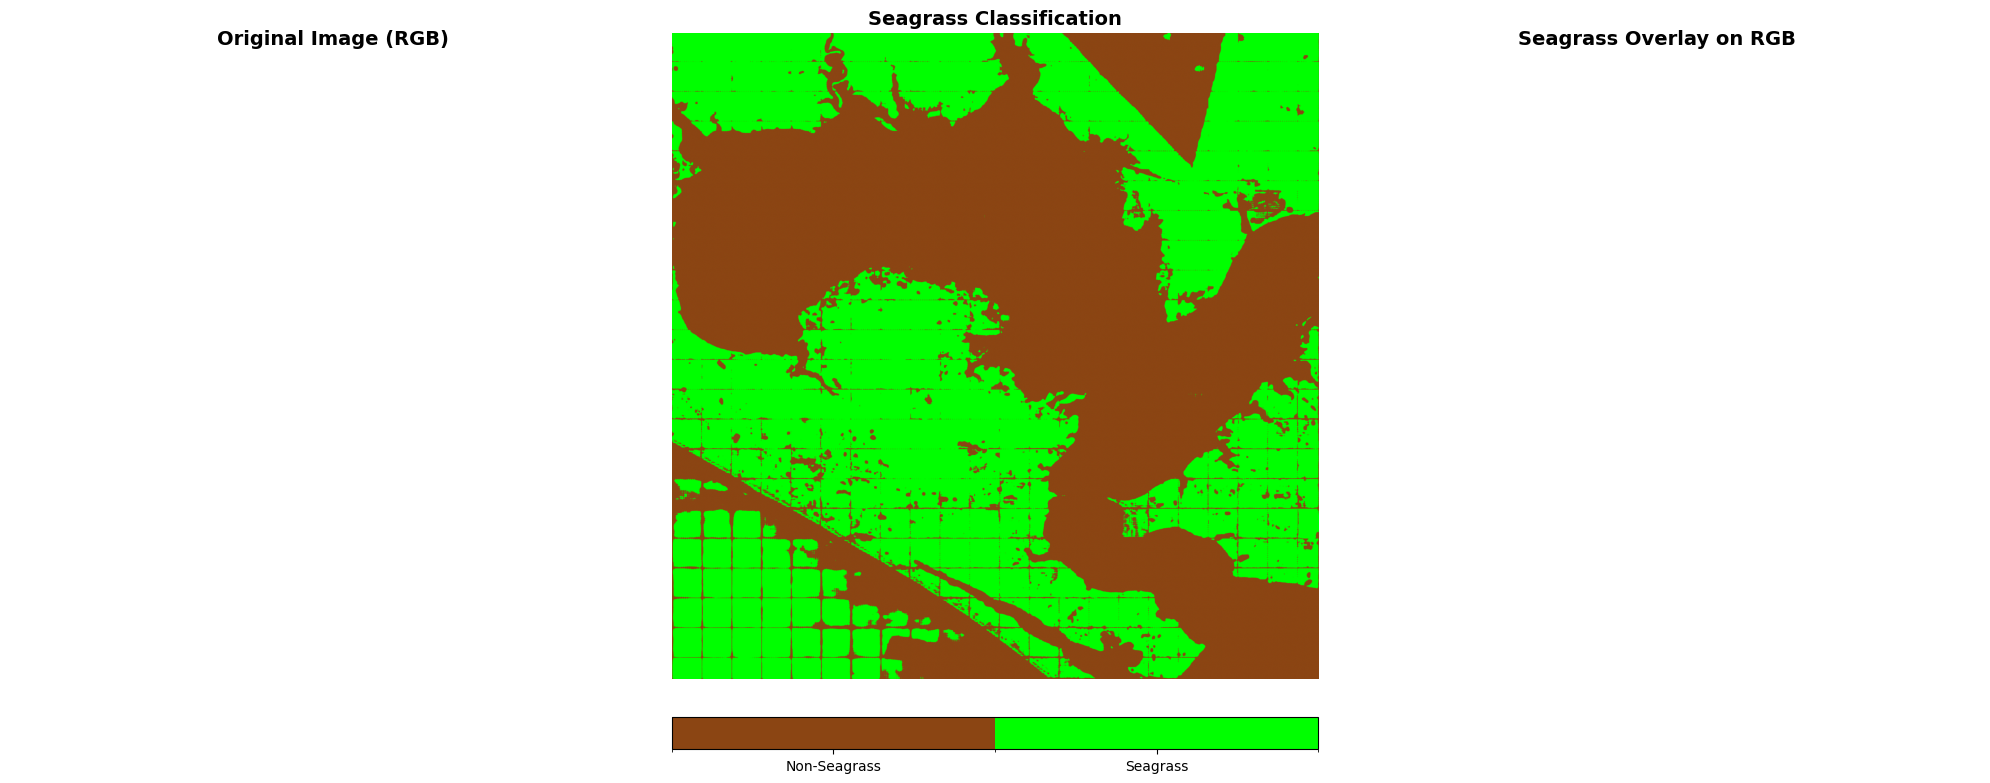


CLASSIFICATION STATISTICS
Total pixels: 23,658,496
Seagrass pixels: 4,151 (0.02%)
Non-Seagrass pixels: 12,387,845 (52.36%)


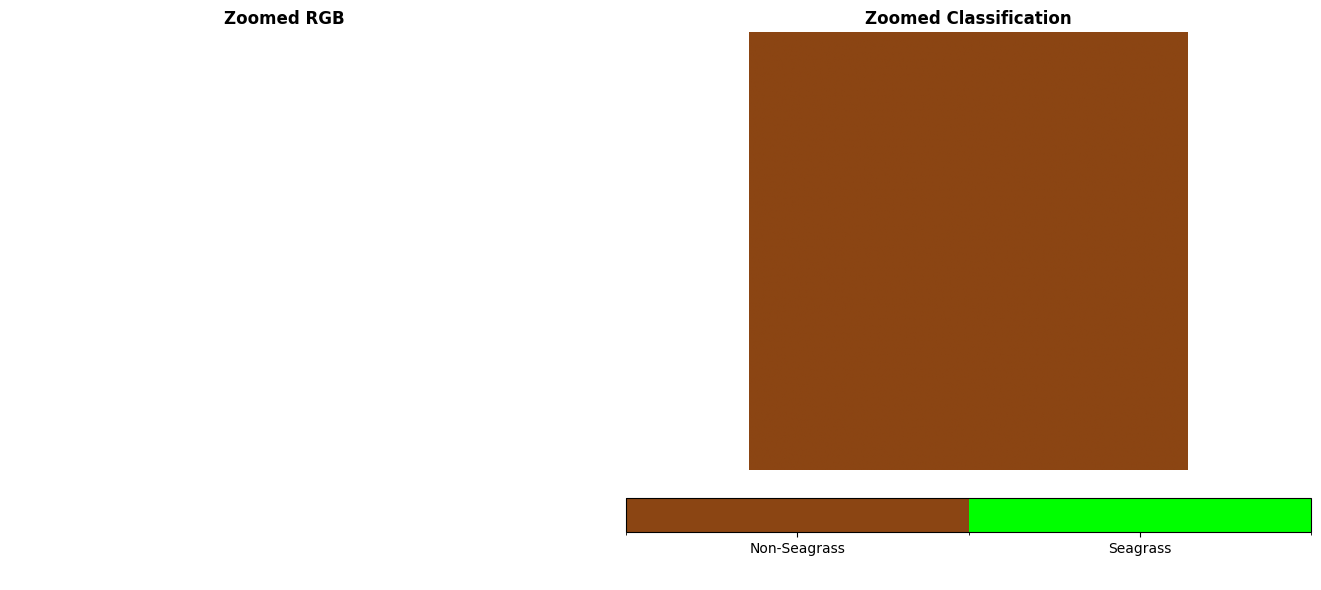

In [34]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import rioxarray

# ============================================================================
# Visualize the results
# ============================================================================

# Load the original image for RGB display
original_image = rioxarray.open_rasterio(input_image_path, masked=True)

# Extract RGB bands (assuming Planet band order: Coastal, Blue, Green I, Green II, Yellow, Red, Red-Edge, NIR)
# Bands: 0=Coastal Blue, 1=Blue, 2=Green I, 5=Red
rgb = original_image[[5, 2, 1], :, :].to_numpy()  # Red, Green, Blue

# Normalize RGB for display
rgb = np.transpose(rgb, (1, 2, 0))  # Convert to (H, W, C)
rgb_normalized = np.clip(rgb / np.percentile(rgb, 99), 0, 1)  # Normalize to 0-1

# Create figure with subplots
fig, axes = plt.subplots(1, 3, figsize=(20, 8))

# Plot 1: Original RGB image
axes[0].imshow(rgb_normalized)
axes[0].set_title('Original Image (RGB)', fontsize=14, fontweight='bold')
axes[0].axis('off')

# Plot 2: Classification result
# Define colors for classes
colors = ['#8B4513', '#00FF00']  # Brown for Non-Seagrass, Green for Seagrass
cmap = mcolors.ListedColormap(colors)
bounds = [0, 1, 2]
norm = mcolors.BoundaryNorm(bounds, cmap.N)

im = axes[1].imshow(prediction, cmap=cmap, norm=norm)
axes[1].set_title('Seagrass Classification', fontsize=14, fontweight='bold')
axes[1].axis('off')

# Add colorbar
cbar = plt.colorbar(im, ax=axes[1], orientation='horizontal', pad=0.05, fraction=0.046)
cbar.set_ticks([0.5, 1.5])
cbar.set_ticklabels(['Non-Seagrass', 'Seagrass'])

# Plot 3: Overlay classification on RGB
overlay = rgb_normalized.copy()
# Create semi-transparent mask for seagrass
seagrass_mask = prediction == 1
overlay[seagrass_mask] = overlay[seagrass_mask] * 0.5 + np.array([0, 1, 0]) * 0.5  # Blend with green

axes[2].imshow(overlay)
axes[2].set_title('Seagrass Overlay on RGB', fontsize=14, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

# ============================================================================
# Print classification statistics
# ============================================================================

total_pixels = prediction.size
seagrass_pixels = np.sum(prediction == 1)
non_seagrass_pixels = np.sum(prediction == 0)

print("\n" + "="*60)
print("CLASSIFICATION STATISTICS")
print("="*60)
print(f"Total pixels: {total_pixels:,}")
print(f"Seagrass pixels: {seagrass_pixels:,} ({100*seagrass_pixels/total_pixels:.2f}%)")
print(f"Non-Seagrass pixels: {non_seagrass_pixels:,} ({100*non_seagrass_pixels/total_pixels:.2f}%)")
print("="*60)

# ============================================================================
# Optional: Create a zoomed-in view of an interesting region
# ============================================================================

# Select a region to zoom into (adjust coordinates as needed)
zoom_y_start, zoom_y_end = 2000, 2500
zoom_x_start, zoom_x_end = 3000, 3500

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Zoomed RGB
axes[0].imshow(rgb_normalized[zoom_y_start:zoom_y_end, zoom_x_start:zoom_x_end])
axes[0].set_title('Zoomed RGB', fontsize=12, fontweight='bold')
axes[0].axis('off')

# Zoomed classification
im = axes[1].imshow(
    prediction[zoom_y_start:zoom_y_end, zoom_x_start:zoom_x_end],
    cmap=cmap,
    norm=norm
)
axes[1].set_title('Zoomed Classification', fontsize=12, fontweight='bold')
axes[1].axis('off')

cbar = plt.colorbar(im, ax=axes[1], orientation='horizontal', pad=0.05)
cbar.set_ticks([0.5, 1.5])
cbar.set_ticklabels(['Non-Seagrass', 'Seagrass'])

plt.tight_layout()
plt.show()

In [35]:
# ============================================================================
# Optional: Interactive visualization (if using ipywidgets)
# ============================================================================

try:
    from ipywidgets import interact, IntSlider

    def show_region(y_center, x_center, size=500):
        """Interactive function to explore different regions of the image."""
        y_start = max(0, y_center - size//2)
        y_end = min(prediction.shape[0], y_center + size//2)
        x_start = max(0, x_center - size//2)
        x_end = min(prediction.shape[1], x_center + size//2)

        fig, axes = plt.subplots(1, 2, figsize=(12, 5))

        axes[0].imshow(rgb_normalized[y_start:y_end, x_start:x_end])
        axes[0].set_title(f'RGB: ({y_start}:{y_end}, {x_start}:{x_end})')
        axes[0].axis('off')

        axes[1].imshow(prediction[y_start:y_end, x_start:x_end], cmap=cmap, norm=norm)
        axes[1].set_title('Classification')
        axes[1].axis('off')

        plt.tight_layout()
        plt.show()

    # Create interactive widget
    interact(
        show_region,
        y_center=IntSlider(min=250, max=prediction.shape[0]-250, step=50, value=prediction.shape[0]//2),
        x_center=IntSlider(min=250, max=prediction.shape[1]-250, step=50, value=prediction.shape[1]//2),
        size=IntSlider(min=200, max=1000, step=100, value=500)
    )

except ImportError:
    print("\nNote: Install ipywidgets for interactive exploration: pip install ipywidgets")


interactive(children=(IntSlider(value=2432, description='y_center', max=4614, min=250, step=50), IntSlider(val…

BELOW HERE IS UNTESTED

-------------------------

-------------------------

-------------------------

In [36]:
# calculate test metrics
trainer.test(model, datamodule=datamodule, ckpt_path=best_ckpt_100_epoch_path)

NameError: name 'best_ckpt_100_epoch_path' is not defined

In [37]:
# get predictions
preds = trainer.predict(model, datamodule=datamodule, ckpt_path=best_ckpt_100_epoch_path)

NameError: name 'best_ckpt_100_epoch_path' is not defined

In [38]:
# get data
data_loader = trainer.predict_dataloaders
batch = next(iter(data_loader))

# plot
for i in range(batch_size):
    sample = {key: batch[key][i] for key in batch}
    sample["prediction"] = preds[0][0][0][i].cpu().numpy()

    datamodule.predict_dataset.plot(sample)

TypeError: 'NoneType' object is not iterable

# Fine-tuning via CLI

We also run the fine-tuning via a [CLI](https://ibm.github.io/terratorch/stable/quick_start/#training-with-lightning-tasks). All parameteres we have specified in the notebook can be put in a [yaml]( ../configs/prithvi_v2_eo_300_tl_unet_multitemporal_crop.yaml), and can be run using the command below. Take a look at the [TerraTorch docs](https://ibm.github.io/terratorch/stable/tutorials/the_yaml_config/) for how to setup the config.

You might want to restart the session to free up GPU memory.

In [ ]:
# First let's get the config file from github.com.
# !git init
# !git remote add origin https://github.com/IBM/ML4EO-workshop-2025.git
# !git fetch --all
# !git checkout origin/main -- "Prithvi-EO/configs/prithvi_v2_eo_300_tl_unet_multitemporal_crop.yaml"

In [ ]:
# # Run fine-tuning
# !terratorch fit -c "Prithvi-EO/configs/prithvi_v2_eo_300_tl_unet_multitemporal_crop.yaml"